In [1]:
import numpy as np
import random

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# code from Jordan
Identity = np.array([[1, 0], [0, 1]])

def tuple_array(arr):
    temp = []
    temp.append(np.size(arr, 0))
    for i in range(np.size(arr, 0)):
        for j in range(np.size(arr, 1)):
            temp.append(arr[i][j])
    return tuple(temp)


def untuple_array(arr):
    temp = []
    N = arr[0]
    for i in range(N):
        temp2 = []
        for j in range(N):
            temp2.append(arr[N*i+j+1])
        temp.append(temp2)
    return np.array(temp)

# Small set of quantum gates
small_dict = {
    'Identity': np.array([[1, 0], [0, 1]]),
    'X': np.array([[0, 1], [1, 0]]),
    'CNOT': np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]),
    'TONC': np.array([[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),
    'Hadamard': (1/(2**(1/2)))*np.array([[1, 1], [1, -1]]),
    'Pi8': np.array([[1, 0], [0, np.exp(1j*np.pi/4)]])
}


# Return all possible gates from a given list of size N
def get_gates(N, list_size):
    list = {}
    if(N == 1):
        count = 0
        list[1] = small_dict['Identity']
        list[2] = small_dict['X']
        list[3] = small_dict['Hadamard']
        list[4] = small_dict['Pi8']
    else:
        count = 0
        for i in small_dict:
            for j in range(1, N+1):
                marker = 0
                if(j == 1):
                    temp_matrix = small_dict[i]
                    if(i == 'CNOT' or i == 'TONC'):
                        marker = 1
                else:
                    temp_matrix = Identity
                identity = Identity
                k = 2 + marker
                double = False
                while(k < N+1):
                    if(k == j):
                        if(k == N and (i == 'CNOT' or i == 'TONC')):
                            double = True
                        else:
                            temp_matrix = np.kron(temp_matrix, small_dict[i])
                        if(i == 'CNOT' or i == 'TONC'):
                            k += 1
                    else:
                        temp_matrix = np.kron(temp_matrix, identity)
                    k += 1
                if(j!=1 and i=='Identity'):
                    double = True
                if(not double):
                    list[count] = temp_matrix
                    count += 1
    return(list)


# Produce training data for a 4x4 matrix
# Returns an array which has the array of inputs as the first element
# and the array of outputs as the second element
def get_training_data(N):
    # Setup to build training data
    inputs = []
    outputs = []
    gates_list = get_gates(N, "small")
    identity_hit_count = 0
    inverse_hit_count = 0

    # Build training data
    # i*j is the number of data points
    for i in range(100000):
        input_matrix = np.kron(Identity, Identity)
        for j in range(50):
            identity = np.identity(2**N)
            dont_add = True
            while(dont_add):
                dont_add = False
                temp = gates_list[random.choice(list(gates_list.keys()))]
                if(tuple_array(temp) == tuple_array(identity)):
                    dont_add = True
                    identity_hit_count += 1
                if(outputs):
                    if(tuple_array(np.matmul(outputs[-1], temp)) == tuple_array(identity)):
                        dont_add = True
                        inverse_hit_count += 1
                if(not dont_add):
                    input_matrix = np.dot(input_matrix, temp)
                    inputs.append(input_matrix)
                    outputs.append(temp)

    # Print the first 10 inputs and outputs if you want
    # for i in range(10):
    #     print(str(i+1) + ':')
    #     print(inputs[i])
    #     print(outputs[i])

    # Print number of times the identity or an inverse is chosen and ignored
    # print("identity_hit_count: " + str(identity_hit_count))
    # print("inverse_hit_count: " + str(inverse_hit_count))

    return [inputs, outputs]

In [2]:
# get the list of inputs and outputs
inputs, outputs = get_training_data(2)
print('inputs length:', len(inputs))
print('outputs length:', len(outputs))
# take a look at some of the input output pairs to get a better idea of the data
# it looks like there are multiple matrces that are the same that have different outputs...
# for i in range(5):
#         print(str(i+1) + ':')
#         print(inputs[i])
#         print(outputs[i])

inputs length: 5000000
outputs length: 5000000


In [3]:
# split up each input matrix into a real part matrix and an imaginary part matrix.
# inputs[12].real

# inputs_real = np.array([])
# inputs_imag = np.array([])
# for i in inputs:
#     np.append(inputs_real, i.real)
#     np.append(inputs_imag, i.imag)

inputs_real = []
inputs_imag = []
for i in inputs:
    inputs_real.append(i.real)
    inputs_imag.append(i.imag)
inputs_r = np.asarray(inputs_real)
inputs_i = np.asarray(inputs_imag)
inputs_ = np.stack([inputs_r, inputs_i], 3)
inputs_.shape # 10000, 4, 4, 2

(5000000, 4, 4, 2)

In [4]:
# next get outputs into np array (10000, 1)
outputs_ = np.asarray(outputs)
outputs_.shape # 10000, 4, 4 

(5000000, 4, 4)

In [5]:
#the possible outputs from Jordan
one = np.array([[0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

two = np.array([[0, 1, 0, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]])

three = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 1, 0]])
four = np.array([[ 0.70710678,  0.,          0.70710678,  0.        ],
                 [ 0.,          0.70710678,  0.,          0.70710678],
                 [ 0.70710678,  0.,         -0.70710678, -0.,        ],
                 [ 0.,          0.70710678, -0.,         -0.70710678]])

five = np.array([[ 0.70710678,  0.70710678,  0.,          0.        ],
 [ 0.70710678, -0.70710678,  0.,         -0.        ],
 [ 0.,          0.,          0.70710678,  0.70710678],
 [ 0.,         -0.,          0.70710678, -0.70710678]])

six = np.array([[1.        +0.j,         0.        +0.j,         0.        +0.j,
  0.        +0.j        ],
 [0.        +0.j,         1.        +0.j,         0.        +0.j,
  0.        +0.j        ],
 [0.        +0.j,         0.        +0.j,         0.70710678+0.70710678j,
  0.        +0.j        ],
 [0.        +0.j,         0.        +0.j,         0.        +0.j,
  0.70710678+0.70710678j]])

seven = np.array([[1.        +0.j,         0.        +0.j,         0.        +0.j,
  0.        +0.j        ],
 [0.        +0.j,         0.70710678+0.70710678j, 0.        +0.j,
  0.        +0.j        ],
 [0.        +0.j,         0.        +0.j,         1.        +0.j,
  0.        +0.j        ],
 [0.        +0.j,         0.        +0.j,         0.        +0.j,
  0.70710678+0.70710678j]])

eight = np.array([[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1]])

nine = np.array([[0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1]])

In [6]:
# map the output matricies to classes 1, 2, 3.. 
output_classes = []
count = 0

for i in range(len(outputs)):
    if (np.allclose(one, outputs[i])):
        output_classes.append(1)
    elif (np.allclose(two, outputs[i])):
        output_classes.append(2)
    elif (np.allclose(three, outputs[i])):
        output_classes.append(3)
    elif (np.allclose(four, outputs[i])):
        output_classes.append(4)
    elif (np.allclose(five, outputs[i])):
        output_classes.append(5)
    elif (np.allclose(six, outputs[i])):
        output_classes.append(6)
    elif (np.allclose(seven, outputs[i])):
        output_classes.append(7)
    elif (np.allclose(eight, outputs[i])):
        output_classes.append(8)
    elif (np.allclose(nine, outputs[i])):
        output_classes.append(9)
    else: 
#         print('error')
        count += 1
        output_classes.append(-1)

print(len(output_classes))
print(count)
    

5000000
0


In [7]:
# this way isnt working for all outputs. must get all the unique arrays in the 
# outputs list, for now just use the ones that work. outputs (1,2,3,8,9)
# get indecies where output_classes = -1 and remove those indecies from inputs and ouptuclasses
outputss = np.array(output_classes)
indecies = np.where(outputss == -1)
outputss = np.delete(outputss, indecies)
inputs_ = np.delete(inputs_, indecies, axis=0)
print(outputss.shape, inputs_.shape)

(5000000,) (5000000, 4, 4, 2)


In [8]:
# outputss[outputss == 8] = 0
# outputss[outputss == 9] = 4

# inputs_[[0,1]]
# inputs_.shape[0]
# np.unique(outputss)

In [9]:
# split into train and test and normalize the inputs
index = np.arange(inputs_.shape[0])
num_training = int(inputs_.shape[0]*.8)
train_inputs, train_outputs = inputs_[:num_training], outputss[:num_training]
test_inputs, test_outputs = inputs_[num_training:], outputss[num_training:]

# Normalize inputs values between 1 and 0
# lets not for now. 

# num_training
# test_inputs.shape
# train_outputs.shape

In [10]:
# set up the network architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(4, 4, 2)))
model.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(4, 4, 2)))
model.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(4, 4, 2)))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 32)          96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          1056      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          1056      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 32)          4128      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 32)          4128      
Total params: 14,592
Trainable params: 14,592
Non-trainable params: 0
____________________________________________________

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# num of output classes
model.add(layers.Dense(10, activation='softmax'))

In [12]:
# train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs, train_outputs, epochs=10, 
                    validation_data=(test_inputs, test_outputs))

Train on 4000000 samples, validate on 1000000 samples
Epoch 1/10
4000000/4000000 [==============================] - 324s 81us/sample - loss: 1.8707 - accuracy: 0.2727 - val_loss: 1.8389 - val_accuracy: 0.2955
Epoch 2/10
4000000/4000000 [==============================] - 315s 79us/sample - loss: 1.8324 - accuracy: 0.2989 - val_loss: 1.8248 - val_accuracy: 0.3051
Epoch 3/10
4000000/4000000 [==============================] - 310s 77us/sample - loss: 1.8271 - accuracy: 0.3026 - val_loss: 1.8233 - val_accuracy: 0.3037
Epoch 4/10
4000000/4000000 [==============================] - 310s 77us/sample - loss: 1.8224 - accuracy: 0.3056 - val_loss: 1.8204 - val_accuracy: 0.3068
Epoch 5/10
4000000/4000000 [==============================] - 308s 77us/sample - loss: 1.8199 - accuracy: 0.3074 - val_loss: 1.8169 - val_accuracy: 0.3085
Epoch 6/10
4000000/4000000 [==============================] - 312s 78us/sample - loss: 1.8191 - accuracy: 0.3079 - val_loss: 1.8267 - val_accuracy: 0.3029
Epoch 7/10
40000

1000000/1 - 19s - loss: 1.8590 - accuracy: 0.3051


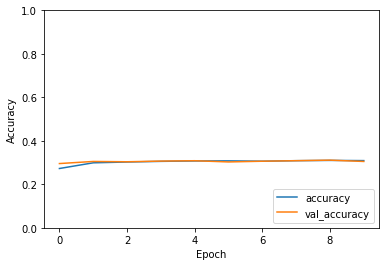

In [13]:
# evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_inputs,  test_outputs, verbose=2)

In [14]:
history.history.keys()
test_acc

0.3051

In [15]:
model.save('nntest.h5')

In [20]:
model.predict(train_inputs[:1])

array([[0.0000000e+00, 9.9742804e-03, 3.4485202e-02, 1.2301239e-02,
        8.9867896e-01, 3.6907393e-02, 4.9177081e-05, 4.7536323e-05,
        0.0000000e+00, 7.5561795e-03]], dtype=float32)